# Musical Instrument Detection

### Loading dataset from Kaggle


In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
gpiosenka_musical_instruments_image_classification_path = kagglehub.dataset_download('gpiosenka/musical-instruments-image-classification')

print('Data source import complete.')
print('Data source path:', gpiosenka_musical_instruments_image_classification_path)


c:\Users\Nouran\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.
Data source path: C:\Users\Nouran\.cache\kagglehub\datasets\gpiosenka\musical-instruments-image-classification\versions\1


In [2]:
print(f"The dataset has been downloaded to: {gpiosenka_musical_instruments_image_classification_path}")

# Optionally, you can also check the directory structure
import os
print("Files in the dataset directory:")
print(os.listdir(gpiosenka_musical_instruments_image_classification_path))

The dataset has been downloaded to: C:\Users\Nouran\.cache\kagglehub\datasets\gpiosenka\musical-instruments-image-classification\versions\1
Files in the dataset directory:
['6 test samples', 'class_dict.csv', 'EfficientNetB3-instruments-99.33.h5', 'instruments.csv', 'test', 'train', 'valid']


### Imports

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import cv2
import random
from keras.utils import img_to_array, load_img
from keras.models import Sequential  # Fixed typo: 'Sequentials' → 'Sequential'
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense,GlobalAveragePooling2D  # Fixed typo: 'flatten' → 'Flatten'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Fixed typo: 'Earlystopping' → 'EarlyStopping'
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


### Adjusting Paths and checking that the Directory Exists

In [4]:
# Adjusting paths to the dataset after downloading it from Kaggle
train_path = "C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/train"
test_path = "C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/test"


# Verify the paths
import os
print(f"Train Path: {train_path}")
print(f"Test Path: {test_path}")

# Check if directories exist
print("Train directory exists:", os.path.exists(train_path))
print("Test directory exists:", os.path.exists(test_path))


Train Path: C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/train
Test Path: C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/test
Train directory exists: True
Test directory exists: True


### Checking the number of Classes & Images

In [21]:
# Check the number of classes in the dataset
class_folders = [folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))]

num_classes = len(class_folders)
# Check the number of images in each class
class_counts = {folder: len(os.listdir(os.path.join(train_path, folder))) for folder in class_folders}
print(f"Number of classes: {num_classes}")
print(f"Class counts: {class_counts } ")
# Check the number of images in the training and test directories
train_images = len(os.listdir(train_path))
test_images = len(os.listdir(test_path))
print(f"Number of training images: {train_images}")
print(f"Number of test images: {test_images}")


Number of classes: 30
Class counts: {'acordian': 209, 'alphorn': 134, 'bagpipes': 137, 'banjo': 155, 'bongo drum': 141, 'casaba': 218, 'castanets': 130, 'clarinet': 133, 'clavichord': 207, 'concertina': 152, 'Didgeridoo': 145, 'drums': 184, 'dulcimer': 126, 'flute': 194, 'guiro': 117, 'guitar': 137, 'harmonica': 142, 'harp': 173, 'marakas': 114, 'ocarina': 127, 'piano': 119, 'saxaphone': 127, 'sitar': 216, 'steel drum': 128, 'Tambourine': 275, 'trombone': 163, 'trumpet': 167, 'tuba': 175, 'violin': 143, 'Xylophone': 205} 
Number of training images: 30
Number of test images: 30


Text(0.5, 0, 'Class Names')

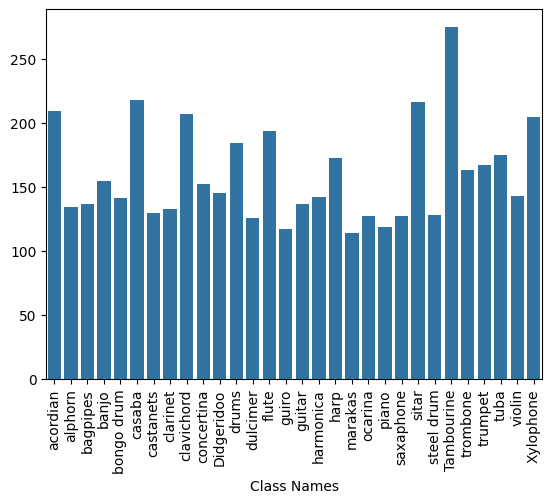

In [6]:
# Plotting the class distribution
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.xlabel('Class Names')

### Displaying Random Images from Dataset

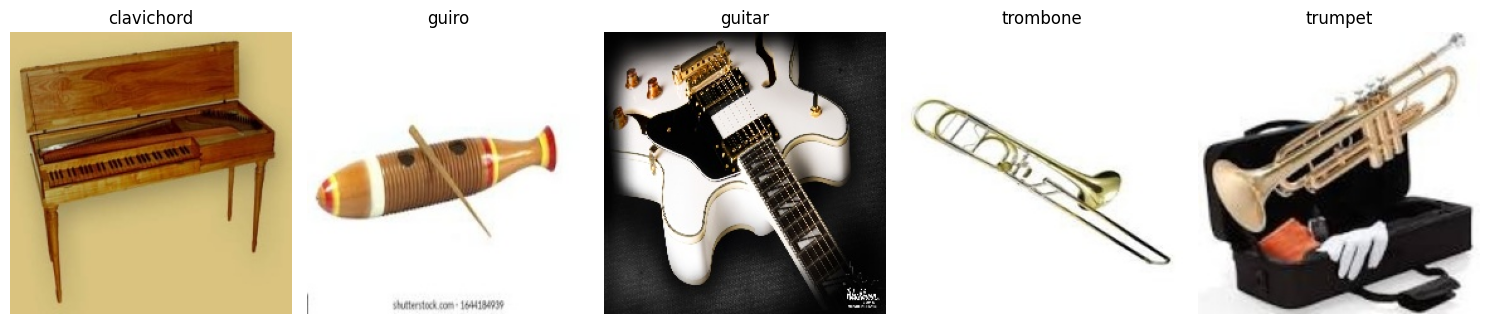

In [22]:
from tensorflow.keras.utils import load_img
from keras.utils import load_img
from tensorflow.keras.preprocessing.image import load_img


# Pick 5 random classes (or all if less than 5)
random_classes = random.sample(class_folders, min(5, len(class_folders)))

# Plot settings
plt.figure(figsize=(15, 5))

for idx, class_name in enumerate(random_classes):
    class_path = os.path.join(train_path, class_name)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if images:
        random_image = random.choice(images)
        img_path = os.path.join(class_path, random_image)
        img = load_img(img_path)

        plt.subplot(1, 5, idx + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
#Parameters
input_shape = (224, 224, 3)
BatchSize = 64
seed = 42
num_classes = 30

In [10]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

In [11]:
# Data Generator for Training Data
train_generator = train_datagen.flow_from_directory(train_path,
                                                      target_size=input_shape[:2],
                                                      batch_size=BatchSize,
                                                      class_mode='categorical',
                                                      seed=seed)

Found 4793 images belonging to 30 classes.


In [12]:
# Data Generator for Validation Data
validation_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Data Generator for Validation Data
validation_generator = validation_datagen.flow_from_directory(test_path,
                                                                target_size=input_shape[:2],
                                                                batch_size=BatchSize,
                                                                class_mode='categorical',
                                                                seed=seed)

Found 150 images belonging to 30 classes.


In [23]:
# Check the class indices
class_indices = train_generator.class_indices

In [24]:
# Check the class indices
print("Class Indices:")
print(class_indices)

Class Indices:
{'Didgeridoo': 0, 'Tambourine': 1, 'Xylophone': 2, 'acordian': 3, 'alphorn': 4, 'bagpipes': 5, 'banjo': 6, 'bongo drum': 7, 'casaba': 8, 'castanets': 9, 'clarinet': 10, 'clavichord': 11, 'concertina': 12, 'drums': 13, 'dulcimer': 14, 'flute': 15, 'guiro': 16, 'guitar': 17, 'harmonica': 18, 'harp': 19, 'marakas': 20, 'ocarina': 21, 'piano': 22, 'saxaphone': 23, 'sitar': 24, 'steel drum': 25, 'trombone': 26, 'trumpet': 27, 'tuba': 28, 'violin': 29}
